In [1]:
import csv
import pandas as pd
import numpy as np
from gensim import corpora
import pickle
import gensim
import re
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
from nltk.corpus import wordnet as wn
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import sys
!{sys.executable} -m pip install gensim

nltk.download('worknet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
%matplotlib inline

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Error loading worknet: Package 'worknet' not found in
[nltk_data]     index
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chuyao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
reddit = pd.read_csv('combined.csv')
reddit.head(1)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""


In [32]:
market = pd.read_csv('market.csv')
abc = pd.read_csv('abc.csv')
abc.head(3)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit


In [33]:
test = abc[abc[['publish_date']]==20060101]
test.publish_date.count()

98

In [34]:
market.head(3)
market['newVolume'] = 0
market['newVolume'] = (market['Volume'] > market['Volume'].shift(1))*1
market.head(3)

,Date,Open,High,Low,Close,Volume,Adj Close,newVolume
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,0
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,1
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,0


In [35]:
market['newDate'] = market['Date'].str.replace('-','')
market['priceChange'] =  (market.Close > market.Open)*1
newMarket = market[['newDate', 'priceChange', 'newVolume']]
newMarket.head(5)

,newDate,priceChange,newVolume
0,20160701,1,0
1,20160630,1,1
2,20160629,1,0
3,20160628,1,1
4,20160627,0,1


In [36]:
# select data between 2008-08-08 to 2016-07-01 
abc = abc.loc[abc['publish_date'] > 20080708].loc[abc['publish_date'] < 20160701]
abc = abc.groupby(['publish_date'])['headline_text'].apply(' '.join).reset_index()
abc

,publish_date,headline_text
0,20080709,22 killed in sri lanka fighting defence minist...
1,20080710,abbott calls for constitutional overhaul abbot...
2,20080711,4 teens injured in rollover 4yo girls rape hor...
3,20080712,4 dead on qld roads 6000 catholics converge on...
4,20080713,21 killed in afghan suicide blast act govt on ...
5,20080714,4000 youths leave newcastle on wyd pilgrimage ...
6,20080715,11th hour bid to avert strike by public servan...
7,20080716,14m to rollout tasers across qld 14yo goes mis...
8,20080717,54yo charged over 9000 child porn images 60s 7...
9,20080718,16yo arrested over latest london stabbing murd...


In [37]:
def get_lemma(word):
    le = wn.morphy(word)
    if le is None:
        return word
    else:
        return le

def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

def prepare_text_for_lda(text):
    tokens = text.split()
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [38]:
abc.rename(columns={'publish_date':'date','headline_text':'headline'}, inplace=True)
abc.head(3)

,date,headline
0,20080709,22 killed in sri lanka fighting defence minist...
1,20080710,abbott calls for constitutional overhaul abbot...
2,20080711,4 teens injured in rollover 4yo girls rape hor...


In [39]:
# Remove STOP WORDS
headlines = list(abc.headline)
tokens = []
for line in headlines:
    line = [word for word in line.split() if not word in en_stop]
    tokens.append(line)
tokens[:1]

[['22',
  'killed',
  'sri',
  'lanka',
  'fighting',
  'defence',
  'ministry',
  '6',
  'killed',
  'turkish',
  'gunfight',
  'outside',
  'us',
  'consulate',
  'abbott',
  'write',
  'book',
  'politics',
  'adelaide',
  'crows',
  'footballer',
  'scott',
  'thompson',
  'makes',
  'adelaide',
  'petrol',
  'prices',
  'rise',
  'agreement',
  'helps',
  'curb',
  'norseman',
  'alcohol',
  'problems',
  'ais',
  'gymnastics',
  'program',
  'build',
  'olympic',
  'culture',
  'alliance',
  'defends',
  'north',
  'south',
  'pipeline',
  'report',
  'amateur',
  'detective',
  'nabs',
  'internet',
  'fraudster',
  'anger',
  'grows',
  'paedophile',
  'presence',
  'annoying',
  'protesters',
  'hold',
  'spoof',
  'fashion',
  'show',
  'anwar',
  'accuses',
  'rudd',
  'abandoning',
  'human',
  'rights',
  'aoc',
  'signs',
  'athletics',
  'squad',
  'beijing',
  'apy',
  'lands',
  'unrest',
  'grows',
  'arsenal',
  'ready',
  'talk',
  'adebayor',
  'say',
  'milan',
  

In [40]:
def getTopics(document):
    NUM_TOPICS = 1
    dictionary = corpora.Dictionary(document)
    corpus = [dictionary.doc2bow(text) for text in document]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=20, alpha='auto')
    topics = ldamodel.print_topics(num_words=50)
    return topics

In [41]:
topics = []
for token in tokens:
    topic = re.findall(r'([a-zA-Z]+)',getTopics([token])[0][1])
    topics.append(topic)
abc['topics'] = np.array(topics)

Text(0.5,1,'Volume changes in years')

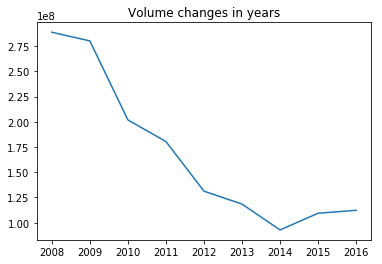

In [42]:
market['Date'] = pd.to_datetime(market['Date'])
market['year'] = market.Date.dt.year
market['month'] = market.Date.dt.month

volume = market.groupby('year')[['Volume']].mean()

plt.plot(volume)

plt.title('Volume changes in years')

Text(0.5,1,'High price changes in years')

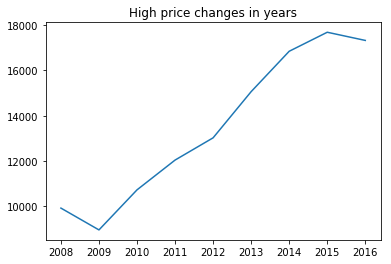

In [25]:
high = market.groupby('year')[['High']].mean()

plt.plot(high)
plt.title('High price changes in years')

In [43]:
abcTopic = abc[['date', 'topics']]
abcTopic = abcTopic.astype({'date':str})

newMarket.rename(columns={'newDate':'date'}, inplace=True)
newMarketReverse = newMarket[::-1]
abcTopic = abcTopic.astype({'date':str})
abc_combined = pd.merge(newMarketReverse, abcTopic, on='date', how='outer')

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [44]:
priceUp = abc_combined[abc_combined['priceChange'] == 0]
words = []
for topic in abc_combined.topics:
    try:
        words += topic
    except:
        continue
str_words = ' '.join(words)

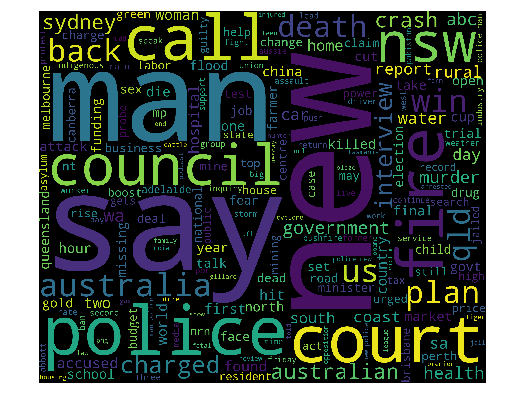

In [45]:
from wordcloud import WordCloud,STOPWORDS
wordcloud_down = WordCloud(background_color='black',
                          width=3000,
                          height=2500
                          ).generate(str_words)
plt.figure(1,figsize=(8,8))
plt.imshow(wordcloud_down)
plt.axis('off')
plt.show()

# Logistic Regression on ABC news Model Words

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import SGDClassifier, SGDRegressor,LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB

In [47]:
train = abc_combined[abc_combined['date'] < '2015-01-01']
test = abc_combined[abc_combined['date'] > '2014-12-31']
train.dropna(inplace=True)
test.dropna(inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [48]:
len(train)/len(test)

2.56120826709062

In [49]:
# Vectorize Features
from sklearn.feature_extraction.text import CountVectorizer

trainheadlines = []
for row in train.topics:
    trainheadlines.append(' '.join(row))

basicvectorizer = CountVectorizer()
basictrain = basicvectorizer.fit_transform(trainheadlines)

print(basictrain.shape)

(1611, 4201)


In [53]:
# Making prediction on test data
testheadlines = []
for row in test.topics:
    testheadlines.append(' '.join(row))

basictest = basicvectorizer.transform(testheadlines)

In [56]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Training Model
basicmodel = LogisticRegression()
basicmodel = basicmodel.fit(basictrain, train["priceChange"])

basic = basicmodel.predict(basictest)

print('accuracy: ', accuracy_score(test['priceChange'], basic))
print('recall_score: ', recall_score(test['priceChange'], basic))
print('precision_score: ', precision_score(test['priceChange'], basic))

accuracy:  0.699523052464229
recall_score:  0.7687687687687688
precision_score:  0.6956521739130435


# Logistic Regression on Volume

In [58]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Training Model
basicmodel = LogisticRegression()
basicmodel = basicmodel.fit(basictrain, train["newVolume"])

basic = basicmodel.predict(basictest)

print('accuracy: ', accuracy_score(test['newVolume'], basic))
print('recall_score: ', recall_score(test['newVolume'], basic))
print('precision_score: ', precision_score(test['newVolume'], basic))

accuracy:  0.6883942766295708
recall_score:  0.6461038961038961
precision_score:  0.6958041958041958


# Naive Bayes on ABC news Model Words

In [59]:
# Training Model
advancedvectorizer = TfidfVectorizer( min_df=0.1, max_df=0.7, max_features = 200000, ngram_range = (1, 1))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)

advancedmodel = MultinomialNB(alpha=0.01)
advancedmodel = advancedmodel.fit(advancedtrain, train["priceChange"])
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
    
advancedtest = advancedvectorizer.transform(testheadlines)
preds4 = advancedmodel.predict(advancedtest)

print('accuracy: ', accuracy_score(test['priceChange'], preds4))
print('recall_score: ', recall_score(test['priceChange'], preds4))
print('precision_score: ', precision_score(test['priceChange'], preds4))

accuracy:  0.5262321144674086
recall_score:  0.978978978978979
precision_score:  0.5283630470016207


# On Volumn Prediction

In [60]:
# Training Model
advancedvectorizer = TfidfVectorizer( min_df=0.1, max_df=0.7, max_features = 200000, ngram_range = (1, 1))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)

advancedmodel = MultinomialNB(alpha=0.01)
advancedmodel = advancedmodel.fit(advancedtrain, train["newVolume"])
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
    
advancedtest = advancedvectorizer.transform(testheadlines)
preds4 = advancedmodel.predict(advancedtest)

print('accuracy: ', accuracy_score(test['newVolume'], preds4))
print('recall_score: ', recall_score(test['newVolume'], preds4))
print('precision_score: ', precision_score(test['newVolume'], preds4))

accuracy:  0.5580286168521462
recall_score:  0.5032467532467533
precision_score:  0.5535714285714286


# Ramdom Forest on ABC news Model Words

In [122]:
advancedvectorizer = TfidfVectorizer( min_df=0.01, max_df=0.99, max_features = 200000, ngram_range = (1, 1))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)

advancedmodel = RandomForestClassifier()
advancedmodel = advancedmodel.fit(advancedtrain, train["priceChange"])

testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
advancedtest = advancedvectorizer.transform(testheadlines)
preds6 = advancedmodel.predict(advancedtest)

print('accuracy: ', accuracy_score(test['priceChange'], preds6))
print('recall_score: ', recall_score(test['priceChange'], preds6))
print('precision_score: ', precision_score(test['priceChange'], preds6))

accuracy:  0.6963434022257552
recall_score:  0.6756756756756757
precision_score:  0.7305194805194806


In [61]:
advancedvectorizer = TfidfVectorizer( min_df=0.01, max_df=0.99, max_features = 200000, ngram_range = (1, 1))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)

advancedmodel = RandomForestClassifier()
advancedmodel = advancedmodel.fit(advancedtrain, train["newVolume"])

testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
advancedtest = advancedvectorizer.transform(testheadlines)
preds6 = advancedmodel.predict(advancedtest)

print('accuracy: ', accuracy_score(test['newVolume'], preds6))
print('recall_score: ', recall_score(test['newVolume'], preds6))
print('precision_score: ', precision_score(test['newVolume'], preds6))

accuracy:  0.6883942766295708
recall_score:  0.5681818181818182
precision_score:  0.7352941176470589


# Logistic Regression on Reddit news Model Words

In [52]:
reddit.rename(columns={'Date':'date'}, inplace=True)
reddit['date'] = reddit['date'].str.replace('-','')
reddit.head(1)

,date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,20080808,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""


In [53]:
headlines = []
for row in range(0,len(reddit.index)):
    headlines.append(' '.join(str(x) for x in reddit.iloc[row,2:27]))
headlines[1]

'b\'Why wont America and Nato help us? If they wont help us now, why did we help them in Iraq?\' b\'Bush puts foot down on Georgian conflict\' b"Jewish Georgian minister: Thanks to Israeli training, we\'re fending off Russia " b\'Georgian army flees in disarray as Russians advance - Gori abandoned to Russia without a shot fired\' b"Olympic opening ceremony fireworks \'faked\'" b\'What were the Mossad with fraudulent New Zealand Passports doing in Iraq?\' b\'Russia angered by Israeli military sale to Georgia\' b\'An American citizen living in S.Ossetia blames U.S. and Georgian leaders for the genocide of innocent people\' b\'Welcome To World War IV! Now In High Definition!\' b"Georgia\'s move, a mistake of monumental proportions " b\'Russia presses deeper into Georgia; U.S. says regime change is goal\' b\'Abhinav Bindra wins first ever Individual Olympic Gold Medal for India\' b\' U.S. ship heads for Arctic to define territory\' b\'Drivers in a Jerusalem taxi station threaten to quit ra

In [68]:
# Generalize, Remove stopwords, 
tokens = []
for line in headlines:
    temp = []
    for word in line.split():
        if word not in en_stop:
            try: 
                w = re.search(r'([a-zA-Z]+)', word.lower()).group(0)
            except:
                continue
            if w != 'b':
                temp.append(w)
    tokens.append(temp)
topics = []
for token in tokens:
    topic = re.findall(r'([a-zA-Z]+)',getTopics([token])[0][1])
    topics.append(topic)

[['downs',
  'two',
  'russian',
  'warplanes',
  'countries',
  'move',
  'brink',
  'war',
  'musharraf',
  'impeached',
  'today',
  'columns',
  'troops',
  'roll',
  'south',
  'ossetia',
  'footage',
  'fighting',
  'youtube',
  'tanks',
  'moving',
  'towards',
  'capital',
  'south',
  'ossetia',
  'reportedly',
  'completely',
  'destroyed',
  'georgian',
  'artillery',
  'fire',
  'children',
  'raped',
  'impunity',
  'u',
  'official',
  'says',
  'sick',
  'three',
  'year',
  'old',
  'raped',
  'nothing',
  'russian',
  'tanks',
  'entered',
  'south',
  'ossetia',
  'whilst',
  'georgia',
  'shoots',
  'two',
  'russian',
  'jets',
  'georgia',
  'invades',
  'south',
  'ossetia',
  'russia',
  'warned',
  'would',
  'intervene',
  'so',
  'side',
  'enemy',
  'combatent',
  'trials',
  'nothing',
  'sham',
  'salim',
  'haman',
  'sentenced',
  'years',
  'kept',
  'longer',
  'anyway',
  'feel',
  'like',
  'it',
  'troops',
  'retreat',
  's',
  'osettain',
  'capita

In [83]:
reddit['topics'] = pd.Series(topics)
reddit_combined = reddit[['date', 'Label', 'topics']]
reddit_combined.head(1)

,date,Label,topics
0,20080808,0,"[south, georgia, ossetia, war, iran, russian, ..."


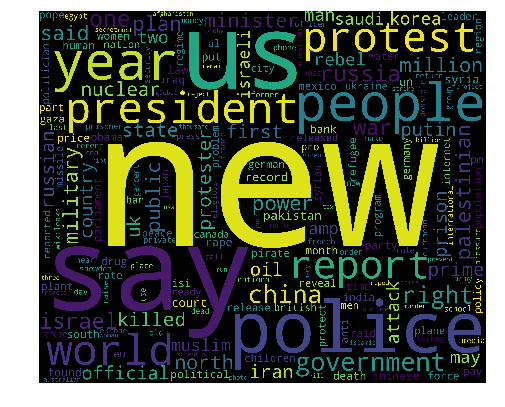

In [86]:
priceUp = reddit_combined[reddit_combined['Label'] == 0]
words = []
for topic in reddit_combined.topics:
    try:
        words += topic
    except:
        continue
str_words = ' '.join(words)
from wordcloud import WordCloud,STOPWORDS
wordcloud_down = WordCloud(background_color='black',
                          width=3000,
                          height=2500
                          ).generate(str_words)
plt.figure(1,figsize=(8,8))
plt.imshow(wordcloud_down)
plt.axis('off')
plt.show()

In [128]:
train = reddit_combined[reddit_combined['date'] < '20150101']
test = reddit_combined[reddit_combined['date'] > '20141231']
train.dropna(inplace=True)
test.dropna(inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [129]:
# Vectorize Features
trainheadlines = []
for row in train.topics:
    trainheadlines.append(' '.join(row))

basicvectorizer = CountVectorizer()
basictrain = basicvectorizer.fit_transform(trainheadlines)

# Making prediction on test data
testheadlines = []
for row in test.topics:
    testheadlines.append(' '.join(row))

basictest = basicvectorizer.transform(testheadlines)

# Training Model
basicmodel = LogisticRegression()
basicmodel = basicmodel.fit(basictrain, train["Label"])

basic = basicmodel.predict(basictest)
print('accuracy: ', accuracy_score(test['Label'], basic))
print('recall_score: ', recall_score(test['Label'], basic))
print('precision_score: ', precision_score(test['Label'], basic))

accuracy:  0.5079365079365079
recall_score:  0.5729166666666666
precision_score:  0.514018691588785


# Naive Bayes on Reddit News

In [126]:
# Training Model
advancedvectorizer = TfidfVectorizer( min_df=0.1, max_df=0.7, max_features = 200000, ngram_range = (1, 1))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)

advancedmodel = MultinomialNB(alpha=0.01)
advancedmodel = advancedmodel.fit(advancedtrain, train["Label"])
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
    
advancedtest = advancedvectorizer.transform(testheadlines)
preds4 = advancedmodel.predict(advancedtest)

print('accuracy: ', accuracy_score(test['Label'], preds4))
print('recall_score: ', recall_score(test['Label'], preds4))
print('precision_score: ', precision_score(test['Label'], preds4))

accuracy:  0.49206349206349204
recall_score:  0.921875
precision_score:  0.5


# Random Forest on Reddit News

In [130]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

advancedvectorizer = TfidfVectorizer( min_df=0.01, max_df=0.99, max_features = 200000, ngram_range = (1, 1))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)

advancedmodel = RandomForestClassifier()
advancedmodel = advancedmodel.fit(advancedtrain, train["Label"])

testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
advancedtest = advancedvectorizer.transform(testheadlines)
preds6 = advancedmodel.predict(advancedtest)

print('accuracy: ', accuracy_score(test['Label'], preds6))
print('recall_score: ', recall_score(test['Label'], preds6))
print('precision_score: ', precision_score(test['Label'], preds6))

accuracy:  0.48677248677248675
recall_score:  0.4322916666666667
precision_score:  0.49404761904761907
